In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [2]:
from keras import regularizers

In [3]:
import os
import pandas as pd

In [4]:
mylist= os.listdir('Data/')

In [5]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [6]:
labels = pd.DataFrame(feeling_list)
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('Data/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [7]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [8]:
newdf = pd.concat([df3,labels], axis=1)

In [9]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [10]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)

In [11]:
rnewdf=rnewdf.fillna(0)

In [12]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [13]:
trainfeatures = train.iloc[:, :-1]

In [14]:
trainlabel = train.iloc[:, -1:]

In [15]:
testfeatures = test.iloc[:, :-1]

In [16]:
testlabel = test.iloc[:, -1:]

In [17]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [18]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [19]:
X_train.shape

(1517, 216)

In [20]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [21]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

In [23]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [24]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Epoch 1/700
95/95 [==============================] - 3s 29ms/step - loss: 2.3726 - accuracy: 0.1193 - val_loss: 2.3014 - val_accuracy: 0.1212
Epoch 2/700
95/95 [==============================] - 2s 25ms/step - loss: 2.2390 - accuracy: 0.1411 - val_loss: 2.2239 - val_accuracy: 0.1708
Epoch 3/700
95/95 [==============================] - 2s 26ms/step - loss: 2.1720 - accuracy: 0.2083 - val_loss: 2.1614 - val_accuracy: 0.2424
Epoch 4/700
95/95 [==============================] - 2s 26ms/step - loss: 2.1207 - accuracy: 0.2307 - val_loss: 2.1211 - val_accuracy: 0.2424
Epoch 5/700
95/95 [==============================] - 2s 25ms/step - loss: 2.0769 - accuracy: 0.2327 - val_loss: 2.0902 - val_accuracy: 0.2590
Epoch 6/700
95/95 [==============================] - 2s 25ms/step - loss: 2.0375 - accuracy: 0.2637 - val_loss: 2.0713 - val_accuracy: 0.1873
Epoch 7/700
95/95 [==============================] - 2s 26ms/step - loss: 2.0012 - accuracy: 0.2426 - val_loss: 2.0155 - val_accuracy: 0.3058
Epoch 

95/95 [==============================] - 2s 25ms/step - loss: 1.2024 - accuracy: 0.5517 - val_loss: 1.4002 - val_accuracy: 0.4711
Epoch 116/700
95/95 [==============================] - 2s 25ms/step - loss: 1.2010 - accuracy: 0.5425 - val_loss: 1.3849 - val_accuracy: 0.4573
Epoch 117/700
95/95 [==============================] - 2s 25ms/step - loss: 1.1905 - accuracy: 0.5557 - val_loss: 1.3882 - val_accuracy: 0.4408
Epoch 118/700
95/95 [==============================] - 2s 25ms/step - loss: 1.1965 - accuracy: 0.5379 - val_loss: 1.4145 - val_accuracy: 0.4408
Epoch 119/700
95/95 [==============================] - 2s 26ms/step - loss: 1.1964 - accuracy: 0.5432 - val_loss: 1.4641 - val_accuracy: 0.4105
Epoch 120/700
95/95 [==============================] - 2s 25ms/step - loss: 1.1854 - accuracy: 0.5438 - val_loss: 1.4104 - val_accuracy: 0.4435
Epoch 121/700
95/95 [==============================] - 2s 25ms/step - loss: 1.1931 - accuracy: 0.5425 - val_loss: 1.3969 - val_accuracy: 0.4298
Epoch 

Epoch 172/700
95/95 [==============================] - 2s 26ms/step - loss: 1.0865 - accuracy: 0.5873 - val_loss: 1.3782 - val_accuracy: 0.4656
Epoch 173/700
95/95 [==============================] - 2s 26ms/step - loss: 1.0900 - accuracy: 0.5880 - val_loss: 1.3736 - val_accuracy: 0.4325
Epoch 174/700
95/95 [==============================] - 3s 26ms/step - loss: 1.0862 - accuracy: 0.5906 - val_loss: 1.3732 - val_accuracy: 0.4711
Epoch 175/700
95/95 [==============================] - 3s 27ms/step - loss: 1.0792 - accuracy: 0.5979 - val_loss: 1.4031 - val_accuracy: 0.4573
Epoch 176/700
95/95 [==============================] - 3s 27ms/step - loss: 1.0792 - accuracy: 0.5900 - val_loss: 1.3646 - val_accuracy: 0.4573
Epoch 177/700
95/95 [==============================] - 3s 30ms/step - loss: 1.0760 - accuracy: 0.6018 - val_loss: 1.3550 - val_accuracy: 0.4628
Epoch 178/700
95/95 [==============================] - 3s 29ms/step - loss: 1.0811 - accuracy: 0.6012 - val_loss: 1.3760 - val_accuracy:

Epoch 229/700
95/95 [==============================] - 2s 26ms/step - loss: 0.9876 - accuracy: 0.6394 - val_loss: 1.3574 - val_accuracy: 0.4821
Epoch 230/700
95/95 [==============================] - 2s 26ms/step - loss: 0.9839 - accuracy: 0.6322 - val_loss: 1.3551 - val_accuracy: 0.4738
Epoch 231/700
95/95 [==============================] - 2s 26ms/step - loss: 0.9868 - accuracy: 0.6500 - val_loss: 1.3515 - val_accuracy: 0.4793
Epoch 232/700
95/95 [==============================] - 2s 26ms/step - loss: 0.9796 - accuracy: 0.6407 - val_loss: 1.3773 - val_accuracy: 0.4601
Epoch 233/700
95/95 [==============================] - 3s 26ms/step - loss: 0.9793 - accuracy: 0.6341 - val_loss: 1.3509 - val_accuracy: 0.4545
Epoch 234/700
95/95 [==============================] - 2s 26ms/step - loss: 0.9799 - accuracy: 0.6322 - val_loss: 1.3912 - val_accuracy: 0.4270
Epoch 235/700
95/95 [==============================] - 2s 26ms/step - loss: 0.9793 - accuracy: 0.6414 - val_loss: 1.3495 - val_accuracy:

Epoch 286/700
95/95 [==============================] - 2s 26ms/step - loss: 0.8883 - accuracy: 0.6697 - val_loss: 1.3800 - val_accuracy: 0.4573
Epoch 287/700
95/95 [==============================] - 2s 26ms/step - loss: 0.8833 - accuracy: 0.6717 - val_loss: 1.3774 - val_accuracy: 0.4518
Epoch 288/700
95/95 [==============================] - 3s 27ms/step - loss: 0.8806 - accuracy: 0.6684 - val_loss: 1.3260 - val_accuracy: 0.4766
Epoch 289/700
95/95 [==============================] - 3s 27ms/step - loss: 0.8796 - accuracy: 0.6882 - val_loss: 1.3501 - val_accuracy: 0.4490
Epoch 290/700
95/95 [==============================] - 3s 27ms/step - loss: 0.8774 - accuracy: 0.6836 - val_loss: 1.3557 - val_accuracy: 0.4545
Epoch 291/700
95/95 [==============================] - 3s 26ms/step - loss: 0.8778 - accuracy: 0.6803 - val_loss: 1.3682 - val_accuracy: 0.4821
Epoch 292/700
95/95 [==============================] - 2s 26ms/step - loss: 0.8745 - accuracy: 0.6875 - val_loss: 1.3461 - val_accuracy:

Epoch 343/700
95/95 [==============================] - 3s 27ms/step - loss: 0.7777 - accuracy: 0.7271 - val_loss: 1.4525 - val_accuracy: 0.4656
Epoch 344/700
95/95 [==============================] - 3s 27ms/step - loss: 0.7827 - accuracy: 0.7271 - val_loss: 1.3923 - val_accuracy: 0.4545
Epoch 345/700
95/95 [==============================] - 3s 27ms/step - loss: 0.7814 - accuracy: 0.7139 - val_loss: 1.3653 - val_accuracy: 0.4959
Epoch 346/700
95/95 [==============================] - 3s 27ms/step - loss: 0.7785 - accuracy: 0.7245 - val_loss: 1.4301 - val_accuracy: 0.4545
Epoch 347/700
95/95 [==============================] - 3s 27ms/step - loss: 0.7670 - accuracy: 0.7343 - val_loss: 1.4338 - val_accuracy: 0.4270
Epoch 348/700
95/95 [==============================] - 3s 27ms/step - loss: 0.7684 - accuracy: 0.7238 - val_loss: 1.3725 - val_accuracy: 0.4738
Epoch 349/700
95/95 [==============================] - 3s 28ms/step - loss: 0.7703 - accuracy: 0.7225 - val_loss: 1.3972 - val_accuracy:

Epoch 456/700
95/95 [==============================] - 3s 26ms/step - loss: 0.5757 - accuracy: 0.8088 - val_loss: 1.4835 - val_accuracy: 0.4656
Epoch 457/700
95/95 [==============================] - 3s 27ms/step - loss: 0.5761 - accuracy: 0.8022 - val_loss: 1.4879 - val_accuracy: 0.4242
Epoch 458/700
95/95 [==============================] - 3s 27ms/step - loss: 0.5770 - accuracy: 0.8049 - val_loss: 1.4811 - val_accuracy: 0.4656
Epoch 459/700
95/95 [==============================] - 3s 27ms/step - loss: 0.5750 - accuracy: 0.8042 - val_loss: 1.4697 - val_accuracy: 0.4711
Epoch 460/700
95/95 [==============================] - 3s 27ms/step - loss: 0.5683 - accuracy: 0.8121 - val_loss: 1.4869 - val_accuracy: 0.4628
Epoch 461/700
95/95 [==============================] - 3s 27ms/step - loss: 0.5718 - accuracy: 0.8088 - val_loss: 1.4877 - val_accuracy: 0.4518
Epoch 462/700
95/95 [==============================] - 3s 27ms/step - loss: 0.5741 - accuracy: 0.8029 - val_loss: 1.4720 - val_accuracy:

Epoch 513/700
95/95 [==============================] - 3s 35ms/step - loss: 0.4867 - accuracy: 0.8359 - val_loss: 1.5667 - val_accuracy: 0.4408
Epoch 514/700
95/95 [==============================] - 3s 33ms/step - loss: 0.4802 - accuracy: 0.8484 - val_loss: 1.4828 - val_accuracy: 0.4738
Epoch 515/700
95/95 [==============================] - 3s 31ms/step - loss: 0.4867 - accuracy: 0.8596 - val_loss: 1.5420 - val_accuracy: 0.4628
Epoch 516/700
95/95 [==============================] - 3s 29ms/step - loss: 0.4768 - accuracy: 0.8490 - val_loss: 1.5879 - val_accuracy: 0.4463
Epoch 517/700
95/95 [==============================] - 3s 29ms/step - loss: 0.4750 - accuracy: 0.8517 - val_loss: 1.5161 - val_accuracy: 0.4656
Epoch 518/700
95/95 [==============================] - 3s 29ms/step - loss: 0.4794 - accuracy: 0.8457 - val_loss: 1.5198 - val_accuracy: 0.4628
Epoch 519/700
95/95 [==============================] - 3s 29ms/step - loss: 0.4740 - accuracy: 0.8477 - val_loss: 1.4958 - val_accuracy:

Epoch 570/700
95/95 [==============================] - 3s 29ms/step - loss: 0.3981 - accuracy: 0.8813 - val_loss: 1.5948 - val_accuracy: 0.4959
Epoch 571/700
95/95 [==============================] - 3s 29ms/step - loss: 0.3852 - accuracy: 0.8813 - val_loss: 1.6052 - val_accuracy: 0.4573
Epoch 572/700
95/95 [==============================] - 3s 29ms/step - loss: 0.3909 - accuracy: 0.8866 - val_loss: 1.6230 - val_accuracy: 0.4518
Epoch 573/700
95/95 [==============================] - 3s 29ms/step - loss: 0.3851 - accuracy: 0.8866 - val_loss: 1.5893 - val_accuracy: 0.4683
Epoch 574/700
95/95 [==============================] - 3s 29ms/step - loss: 0.3842 - accuracy: 0.8873 - val_loss: 1.6282 - val_accuracy: 0.4463
Epoch 575/700
95/95 [==============================] - 3s 28ms/step - loss: 0.3856 - accuracy: 0.8820 - val_loss: 1.6703 - val_accuracy: 0.4490
Epoch 576/700
95/95 [==============================] - 3s 29ms/step - loss: 0.3777 - accuracy: 0.8906 - val_loss: 1.6114 - val_accuracy:

Epoch 627/700
95/95 [==============================] - 3s 28ms/step - loss: 0.3023 - accuracy: 0.9229 - val_loss: 1.6951 - val_accuracy: 0.4876
Epoch 628/700
95/95 [==============================] - 3s 28ms/step - loss: 0.3072 - accuracy: 0.9169 - val_loss: 1.6766 - val_accuracy: 0.4656
Epoch 629/700
95/95 [==============================] - 3s 31ms/step - loss: 0.3062 - accuracy: 0.9229 - val_loss: 1.6736 - val_accuracy: 0.4656
Epoch 630/700
95/95 [==============================] - 3s 28ms/step - loss: 0.2955 - accuracy: 0.9196 - val_loss: 1.7045 - val_accuracy: 0.4876
Epoch 631/700
95/95 [==============================] - 3s 29ms/step - loss: 0.2980 - accuracy: 0.9209 - val_loss: 1.6885 - val_accuracy: 0.4656
Epoch 632/700
95/95 [==============================] - 3s 28ms/step - loss: 0.2917 - accuracy: 0.9262 - val_loss: 1.7004 - val_accuracy: 0.4738
Epoch 633/700
95/95 [==============================] - 3s 29ms/step - loss: 0.3002 - accuracy: 0.9249 - val_loss: 1.6914 - val_accuracy:

Epoch 684/700
95/95 [==============================] - 3s 28ms/step - loss: 0.2281 - accuracy: 0.9492 - val_loss: 1.8102 - val_accuracy: 0.4848
Epoch 685/700
95/95 [==============================] - 3s 28ms/step - loss: 0.2299 - accuracy: 0.9446 - val_loss: 1.8931 - val_accuracy: 0.4573
Epoch 686/700
95/95 [==============================] - 3s 28ms/step - loss: 0.2305 - accuracy: 0.9473 - val_loss: 1.8345 - val_accuracy: 0.4848
Epoch 687/700
95/95 [==============================] - 3s 28ms/step - loss: 0.2275 - accuracy: 0.9519 - val_loss: 1.8315 - val_accuracy: 0.4711
Epoch 688/700
95/95 [==============================] - 3s 28ms/step - loss: 0.2198 - accuracy: 0.9466 - val_loss: 1.8045 - val_accuracy: 0.4848
Epoch 689/700
95/95 [==============================] - 3s 28ms/step - loss: 0.2251 - accuracy: 0.9446 - val_loss: 1.7951 - val_accuracy: 0.4848
Epoch 690/700
95/95 [==============================] - 3s 28ms/step - loss: 0.2228 - accuracy: 0.9552 - val_loss: 1.8128 - val_accuracy:

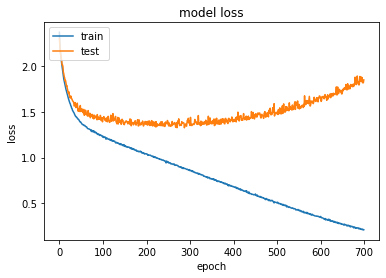

In [25]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

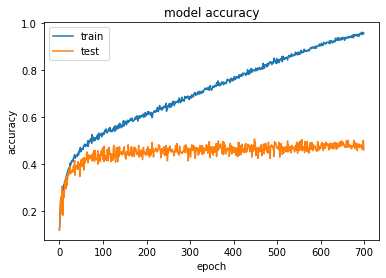

In [26]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()